# this is actually a colab notebook can it can be find [HERE](https://colab.research.google.com/drive/1n3ER-i1u2Oq8e3Bqvcn8WANNdM6vNPkH#scrollTo=o6GhcJhCK0OI)



# Dog breed classification Pytorch

- using Resnet-50

In [1]:
"""
I used this command to download the dataset to colab  I get this link by downloading the full dataset from the competition 
and copying the download link from chrome://downloads/

because maybe in two days that link might change 

"""
!wget "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1622747833&Signature=YsxEdEGo%2BeezaHIuM6jpg5Le2AtpNXPFbEjFTRNekFCM%2BZXacC8lOlkLNKww%2BUfIA%2B12sbNRKRau%2BAY5rn%2BlRCEunbv3U%2BlkR3KTG2mjVR49LETQA%2F27MeRu6t66AiYuI%2BrRYRehyI0ew0FtpkL6J4C0XGj4ZCcBWAElpOIkggMjp0q7o%2BVrEeqDti0aEPUIh7JfomHfuAWbuf3jtLzJiwoJ04ubyrT%2FCWH3eu7tXtt%2B5a%2BtIwh9Hc5HrhLRsIbIsKKeKMZw8nyRhST06pA5q3lYX2DN5cp7kDQ%2FtN6%2FGGwnSBf0nT9EaZ1v1GhFF0imSLQdrNLP4Dih3LUYqkdBHQ%3D%3D&response-content-disposition=attachment%3B+filename%3Ddog-breed-identification.zip"

The name is too long, 534 chars total.
Trying to shorten...
New name is archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1622747833&Signature=YsxEdEGo+eezaHIuM6jpg5Le2AtpNXPFbEjFTRNekFCM+ZXacC8lOlkLNKww+UfIA+12sbNRKRau+AY5rn+lRCEunbv3U+lkR3KTG2mjVR49LETQA%2F27MeRu6t66AiYuI+r.
--2021-05-31 21:22:21--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1622747833&Signature=YsxEdEGo%2BeezaHIuM6jpg5Le2AtpNXPFbEjFTRNekFCM%2BZXacC8lOlkLNKww%2BUfIA%2B12sbNRKRau%2BAY5rn%2BlRCEunbv3U%2BlkR3KTG2mjVR49LETQA%2F27MeRu6t66AiYuI%2BrRYRehyI0ew0FtpkL6J4C0XGj4ZCcBWAElpOIkggMjp0q7o%2BVrEeqDti0aEPUIh7JfomHfuAWbuf3jtLzJiwoJ04ubyrT%2FCWH3eu7tXtt%2B5a%2BtIwh9Hc5HrhLRsIbIsKKeKMZw8nyRhST06pA5q3lYX2DN5cp7kDQ%2FtN6%2FGGwnSBf0nT9EaZ1v1GhFF0imSLQdrNLP4Dih3LUYqkdBHQ%3D%3D&response-content-disposition=attachment%3B+filename%3Ddog-breed-identification.zip
Resolving stora

In [ ]:
"""

"""
!unzip "/content/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1622747833&Signature=YsxEdEGo+eezaHIuM6jpg5Le2AtpNXPFbEjFTRNekFCM+ZXacC8lOlkLNKww+UfIA+12sbNRKRau+AY5rn+lRCEunbv3U+lkR3KTG2mjVR49LETQA%2F27MeRu6t66AiYuI+r"

In [36]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchmetrics as metrics
from sklearn.model_selection import train_test_split

In [81]:
# Read the csv files
comp_df = pd.read_csv('./labels.csv')
test_df = pd.read_csv('./sample_submission.csv')

# How many number of images in Training set and test set?
print('Training set: {}, Test set: {}'.format(comp_df.shape[0],test_df.shape[0]))

Training set: 10222, Test set: 10357


getting only the wanted breeds

In [82]:
comp_df = comp_df.loc[comp_df["breed"].isin(["beagle","chihuahua","doberman","french_bulldog","golden_retriever","malamute","pug","saint_bernard","scottish_deerhound","tibetan_mastiff"])]

# Prepare dataframe for training set

- Prepare dataframe with two columns: complete file path and labels (transferd to index)
- Create a index-2-breed dictionary

In [83]:
# Encode the breed into digits
comp_df['label'] = LabelEncoder().fit_transform(comp_df.breed)

# Create a breed-2-index dictionary
dict_df = comp_df[['label','breed']].copy()
dict_df.drop_duplicates(inplace=True)
dict_df.set_index('label',drop=True,inplace=True)
index_to_breed = dict_df.to_dict()['breed']

In [84]:
# Change the id to full file path
train_dir = './train'
comp_df.id = comp_df.id.apply(lambda x:train_dir+'/'+x+'.jpg')

# Drop the breed column
# comp_df.pop('breed')

In [85]:
comp_df

,id,breed,label
4,./train/0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever,4
9,./train/0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound,8
20,./train/008b1271ed1addaccf93783b39deab45.jpg,doberman,2
25,./train/00a366d4b4a9bbb6c8a63126697b7656.jpg,golden_retriever,4
37,./train/0100f55e4f0fe28f2c0465d3fc4b9897.jpg,golden_retriever,4
...,...,...,...
10158,./train/fe50bac6c389d137ea01c9cfc7346ca8.jpg,scottish_deerhound,8
10161,./train/fe624532170510bd80627c0500bafc97.jpg,tibetan_mastiff,9
10170,./train/feb16cf86c9dac6d476e3c372ba5c279.jpg,pug,6
10172,./train/febcab8eb2da444bf83336cffec7eb92.jpg,golden_retriever,4


as the dataset is not so  big I will   

# Have a look on the images

In [29]:
def show_images(df,img_num):
    sample = df.sample(img_num)
    paths = sample.id.tolist()
    for path in paths:
        plt.figure(figsize=(3,3))
        img = plt.imread(path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

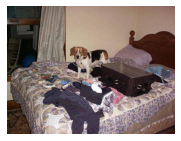

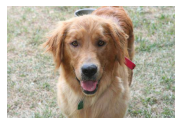

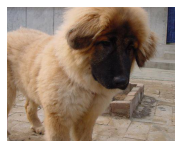

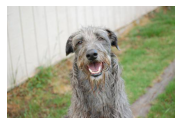

In [30]:
show_images(comp_df,4)

# Create Custom Dataset class and transformers

In [45]:
class img_dataset(Dataset):
    def __init__(self,dataframe,transform=None,test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.test = test
        
    def __getitem__(self,index):
        x = Image.open(self.dataframe.iloc[index,0])
        if self.transform:
            x = self.transform(x)
        if self.test:
            return x
        else:
            y = self.dataframe.iloc[index,2]
            return x,y
        
    def __len__(self):
        return self.dataframe.shape[0]

In [32]:
# Creat transforms
train_transformer = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.RandomRotation(15),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transformer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Main Training function

In [57]:
# Print the result of 1 epoch
def print_epoch_result(train_loss,train_acc,val_loss,val_acc,f1,rocAuc):
    print('loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}, val_f1: {:.3f}, val_rocAuc: {:.3f}'.format(train_loss,
                                                                              train_acc,
                                                                              val_loss,
                                                                              val_acc,f1,rocAuc))
# Main Training function
def train_model(model, cost_function, optimizer,num_epochs=5):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    # Metrics objects
    train_acc_object = metrics.Accuracy(compute_on_step=False,num_classes=10)
    val_acc_object = metrics.Accuracy(compute_on_step=False,num_classes=10)
    val_f1_object = metrics.F1(compute_on_step=False,num_classes=10)
    val_rocAuc_object = metrics.AUROC(compute_on_step=False,num_classes=10)
    # val_confusion_object = metrics.ConfusionMatrix(compute_on_step=False)
    
    for epoch in range(num_epochs):
        """
        On epoch start
        """
        print('-'*15)
        print('Start training {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # Training
        train_sub_losses = []
        model.train()
        for x,y in train_loader:
            optimizer.zero_grad()
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            loss.backward()
            optimizer.step()
            #lr_scheduler.step()
            # update loss sublist
            train_sub_losses.append(loss.item())
            # update accuracy object
            train_acc_object(y_hat.cpu().softmax(dim=-1),y.cpu()) 
            
        # Validation
        val_sub_losses = []
        model.eval()
        for x,y in val_loader:
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            val_sub_losses.append(loss.item())
            val_acc_object(y_hat.cpu().softmax(dim=-1),y.cpu())
            val_f1_object(y_hat.cpu().softmax(dim=-1),y.cpu())
            val_rocAuc_object(y_hat.cpu().softmax(dim=-1),y.cpu())
            # val_confusion_object(y_hat.cpu(),y.cpu())
            
        """
        On epoch end
        """
        # Update the loss list
        train_losses.append(np.mean(train_sub_losses))
        val_losses.append(np.mean(val_sub_losses))
        
        # Update the accuracy list and reset the metrics object 
        train_epoch_acc = train_acc_object.compute()
        val_epoch_acc = val_acc_object.compute()
        val_epoch_acc = val_acc_object.compute()
        f1 = val_f1_object.compute()
        rocAuc = val_rocAuc_object.compute()
        train_acc.append(train_epoch_acc)
        val_acc.append(val_epoch_acc)
        train_acc_object.reset()
        val_acc_object.reset()
        
        # print the result of epoch
        print_epoch_result(np.mean(train_sub_losses),train_epoch_acc,np.mean(val_sub_losses),val_epoch_acc,f1,rocAuc)
        
    print('Finish Training.')
    return train_losses, train_acc, val_losses, val_acc

Now the main training function is finished, lets preprare the model, dataset, cost function and optimizer.

In [34]:
# Setting up gpu
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [46]:
# Parameters for dataset
training_samples = comp_df.shape[0] # Use small number first to test whether the model is doing well, then change back to full dataset
test_size=0.2
batch_size = 64

# Reduce the number of samples
sample_df =comp_df # comp_df.sample(training_samples)

# Split the comp_df into training set and validation set
x_train,x_val,_,_ = train_test_split(sample_df,sample_df,test_size=test_size)

# Create dataloaders form datasets
train_set = img_dataset(x_train, transform=train_transformer)
val_set = img_dataset(x_val, transform=val_transformer)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set , batch_size=batch_size, shuffle=True)

# How many images in training set and val set?
print('Training set: {}, Validation set: {}'.format(x_train.shape[0],x_val.shape[0]))

Training set: 672, Validation set: 169


Create model
- a resnet-50 as a base model (with parameters freezed)
- Two dense layers added at the end.

In [40]:
# Use resnet-50 as a base model
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

res = torchvision.models.resnet50(pretrained=True)
for param in res.parameters():
    param.requires_grad=False

model_final = net(base_model=res, base_out_features=res.fc.out_features, num_classes=comp_df.label.nunique())
model_final = model_final.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [41]:
# Cost function and optimzier
cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model_final.parameters() if param.requires_grad], lr=0.0003)

# Epoch 
EPOCHS = 10

In [58]:
# Start Training
model, train_losses, train_acc, val_losses, val_acc = train_model(model=model_final, 
                                                           cost_function=cost_function, 
                                                           optimizer=optimizer,
                                                           num_epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


---------------
Start training 1/10
---------------
loss: 0.449, acc: 0.857, val_loss: 0.140, val_acc: 0.959, val_f1: 0.959, val_rocAuc: 1.000
---------------
Start training 2/10
---------------
loss: 0.388, acc: 0.888, val_loss: 0.120, val_acc: 0.964, val_f1: 0.962, val_rocAuc: 1.000
---------------
Start training 3/10
---------------
loss: 0.376, acc: 0.899, val_loss: 0.137, val_acc: 0.953, val_f1: 0.959, val_rocAuc: 1.000
---------------
Start training 4/10
---------------
loss: 0.335, acc: 0.903, val_loss: 0.117, val_acc: 0.953, val_f1: 0.957, val_rocAuc: 0.999
---------------
Start training 5/10
---------------
loss: 0.350, acc: 0.888, val_loss: 0.127, val_acc: 0.959, val_f1: 0.957, val_rocAuc: 0.999
---------------
Start training 6/10
---------------
loss: 0.347, acc: 0.893, val_loss: 0.114, val_acc: 0.964, val_f1: 0.959, val_rocAuc: 0.999
---------------
Start training 7/10
---------------
loss: 0.281, acc: 0.923, val_loss: 0.120, val_acc: 0.964, val_f1: 0.959, val_rocAuc: 0.999

the validation set has  better metrics than the train set maybe because the easier images for the model was selected by luck

# Plot the result

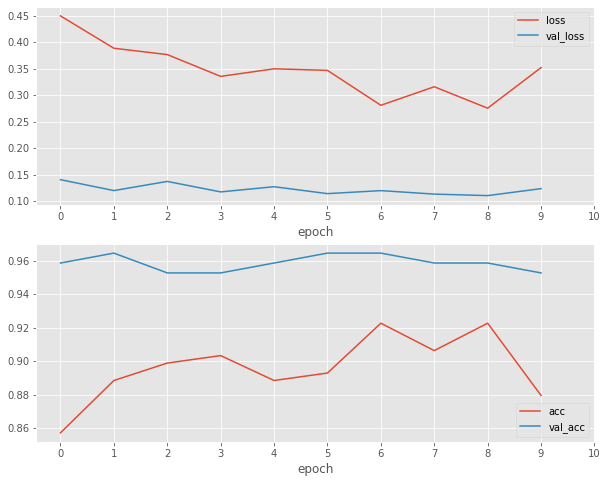

In [59]:
def plot_result(train_loss,val_loss,train_acc,val_acc):
    plt.style.use('ggplot')
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
    ax1.plot(train_loss,label='loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.legend()
    ax1.set_xlabel('epoch')
    ax1.set_xticks(range(0,EPOCHS+1))
    ax2.plot(train_acc, label='acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.legend()
    ax2.set_xlabel('epoch')
    ax2.set_xticks(range(0,EPOCHS+1))
    plt.show()
plot_result(train_losses,val_losses, train_acc,  val_acc)

In [64]:
index_to_breed

{0: 'beagle',
 1: 'chihuahua',
 2: 'doberman',
 3: 'french_bulldog',
 4: 'golden_retriever',
 5: 'malamute',
 6: 'pug',
 7: 'saint_bernard',
 8: 'scottish_deerhound',
 9: 'tibetan_mastiff'}

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


loss: -1.000, acc: -1.000, val_loss: 0.145, val_acc: 0.953, val_f1: 0.953, val_rocAuc: 0.999
Confusion matrix, without normalization
[[22.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 16.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 12.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0. 12.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  8.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0. 14.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0. 19.  0.  0.  0.]
 [ 2.  0.  0.  0.  0.  0.  0. 16.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 24.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0. 18.]]


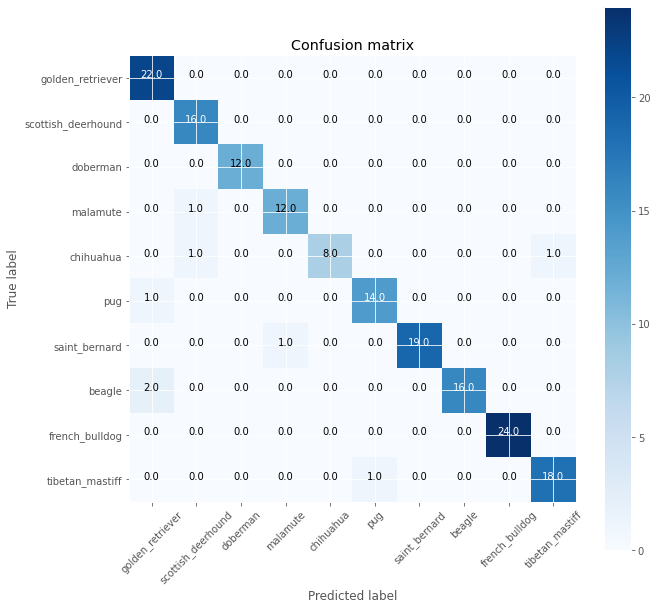

In [80]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(valtrues.numpy(),valpreds.numpy())
# Metrics objects
train_acc_object = metrics.Accuracy(compute_on_step=False,num_classes=10)
val_acc_object = metrics.Accuracy(compute_on_step=False,num_classes=10)
val_f1_object = metrics.F1(compute_on_step=False,num_classes=10)
val_rocAuc_object = metrics.AUROC(compute_on_step=False,num_classes=10)
val_confusion_object = metrics.ConfusionMatrix(compute_on_step=False,num_classes=10)
val_sub_losses = []
model_final.eval()
for x,y in val_loader:
    x,y = x.to(device),y.to(device)
    y_hat = model_final(x)
    loss = cost_function(y_hat,y)
    val_sub_losses.append(loss.item())
    val_acc_object(y_hat.cpu().softmax(dim=-1),y.cpu())
    val_f1_object(y_hat.cpu().softmax(dim=-1),y.cpu())
    val_rocAuc_object(y_hat.cpu().softmax(dim=-1),y.cpu())
    val_confusion_object(y_hat.cpu().softmax(dim=-1),y.cpu())


cm =  val_confusion_object.compute()
train_epoch_acc = train_acc_object.compute()
val_epoch_acc = val_acc_object.compute()
f1 = val_f1_object.compute()
rocAuc = val_rocAuc_object.compute()

# print the result of epoch
print_epoch_result(-1,-1,np.mean(val_sub_losses),val_epoch_acc,f1,rocAuc)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.1f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(cm.numpy(),index_to_breed.values())

Saving the model so I can use it for the api

In [92]:
checkpoint = {"arch":net(base_model=res, base_out_features=res.fc.out_features, num_classes=comp_df.label.nunique()),
              "state_dict":model_final.state_dict()
              }
torch.save(checkpoint,"dogbreedsTask.pth")

In [91]:
from google.colab import drive

drive.mount("gdrive")

Mounted at gdrive


In [93]:
!cp  "./dogbreedsTask.pth" "/content/gdrive/MyDrive"